In [1388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta, date
import yfinance as yf
from joblib import Parallel, delayed
from functools import partial
from tqdm import tqdm
import ffn

## load data

yfinance only allow grabing the data by 7 days at 1m level, plus must be within the last 729 days

In [1389]:
start_date = date.today() - timedelta(days=729)
end_date = date.today()

In [1390]:
# Load data

In [1391]:
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter


# Define a class combining caching and rate-limiting
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass


# Create a session with caching and rate-limiting
session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND * 5)),  # Max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

# Set the User-Agent header
session.headers["User-agent"] = "my-program/1.0"

In [1392]:
# Define a function that downloads data for a given symbol at 1m interval
download_data = partial(yf.download, session=session, interval='1h')

In [1393]:
df = download_data(['TQQQ', 'SPY'], start=start_date, end=end_date)

[*********************100%%**********************]  2 of 2 completed


In [1394]:
df.index = df.index.tz_localize(None)

<Axes: xlabel='Datetime'>

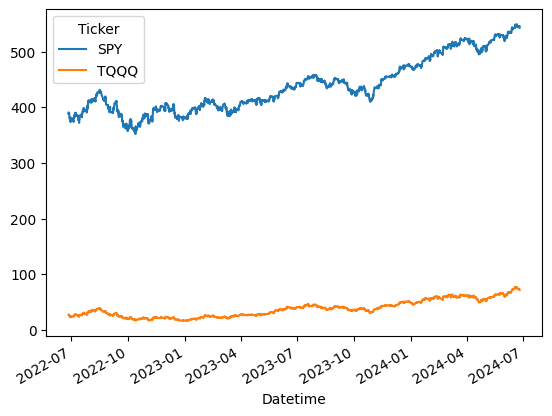

In [1395]:
df['Adj Close'].plot()

## Basic parameters

In [1396]:
spy_fee = 0.0945 / 100  # 0.0945% per annual
spy_fee_per_hour = spy_fee / 252 / 21 / 6.5
qqq_fee = 0.05 / 100  # 0.05% per annual
qqq_fee_per_hour = qqq_fee / 252 / 21 / 6.5
tqqq_fee = 0.95 / 100  # 0.95% per annual
tqqq_fee_per_hour = tqqq_fee / 252 / 21 / 6.5
transaction_fee = 0.00025  # 2.5 bp per transaction

# ETF Arbitrage with SPY and TQQQ

In [1397]:
spread = pd.DataFrame(df['Adj Close']['SPY'] - df['Adj Close']['TQQQ'], columns=['spread'])
spread['de_trend'] = spread.diff()

<Axes: xlabel='Datetime'>

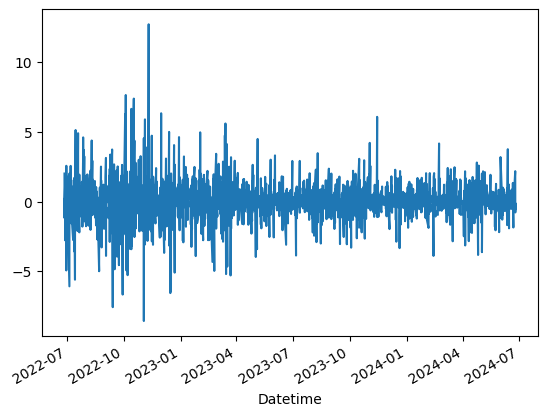

In [1398]:
spread['de_trend'].plot()

In [1399]:
def bbo_spread_estimates(data):
    """Corwin-Schultz Spread Estimator"""
    if len(data) < 2:
        return None
    data.columns = data.columns.droplevel(1)
    beta = data.apply(lambda x: np.log(x['High'] / x['Low']) ** 2, axis=1).sum()
    h = max(data['High'])
    l = min(data['Low'])
    gamma = np.log(h / l) ** 2
    alpha = (np.sqrt(2 * beta) - np.sqrt(beta)) / (3 - 2 * np.sqrt(2) - np.sqrt(gamma / (3 - 2 * np.sqrt(2))))
    s = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))
    return s

In [1400]:
execution_df = pd.DataFrame(index=df.index)

tmp = df.loc[:, [('High', 'SPY'), ('Low', 'SPY')]]
execution_df['SPY_estimated_spread'] = [None] + [bbo_spread_estimates(tmp.iloc[i - 1:i + 1]) for i in range(1, len(df))]
tmp = df.loc[:, [('High', 'TQQQ'), ('Low', 'TQQQ')]]
execution_df['TQQQ_estimated_spread'] = [None] + [bbo_spread_estimates(tmp.iloc[i - 1:i + 1]) for i in
                                                  range(1, len(df))]
execution_df['SPY_Ask'] = df['Close']['SPY'] + execution_df['SPY_estimated_spread'] / 2
execution_df['SPY_Bid'] = df['Close']['SPY'] - execution_df['SPY_estimated_spread'] / 2
execution_df['TQQQ_Ask'] = df['Close']['TQQQ'] + execution_df['TQQQ_estimated_spread'] / 2
execution_df['TQQQ_Bid'] = df['Close']['TQQQ'] - execution_df['TQQQ_estimated_spread'] / 2

In [1401]:
execution_df

,SPY_estimated_spread,TQQQ_estimated_spread,SPY_Ask,SPY_Bid,TQQQ_Ask,TQQQ_Bid
Datetime,,,,,,
2022-06-27 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-27 10:30:00,0.034496,0.398992,390.907263,390.872767,28.189496,27.790504
2022-06-27 11:30:00,0.025891,0.159762,389.152960,389.127069,27.499881,27.340119
2022-06-27 12:30:00,0.017634,0.115407,389.228818,389.211184,27.592703,27.477297
2022-06-27 13:30:00,0.012904,0.060856,388.606458,388.593554,27.376429,27.315573
...,...,...,...,...,...,...
2024-06-24 11:30:00,0.008486,0.063327,545.969270,545.960784,73.621767,73.558440
2024-06-24 12:30:00,0.010770,0.062017,544.275405,544.264634,72.707011,72.644994
2024-06-24 13:30:00,0.011680,0.069089,543.775860,543.764179,72.294547,72.225457


In [1402]:
# we assume our initial capital is the maximum of the sum of pair of ETFs
initial_capital = (execution_df['SPY_Ask'] + execution_df['TQQQ_Ask']).max()

In [1403]:
def open_long_spread(row):
    entry_spy = row['SPY_Ask'] * (1 + transaction_fee)  # long SPY
    entry_tqqq = row['TQQQ_Bid'] * (1 - transaction_fee)  # short TQQQ
    spy_exit = row['SPY_Bid'] * (1 - transaction_fee)
    tqqq_exit = row['TQQQ_Ask'] * (1 + transaction_fee)
    unrealized_spy_pnl = spy_exit - entry_spy
    unrealized_tqqq_pnl = entry_tqqq - tqqq_exit
    return entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl


def hold_long_spread(row, entry_spy, entry_tqqq):
    spy_exit = row['SPY_Bid'] * (1 - transaction_fee)
    tqqq_exit = row['TQQQ_Ask'] * (1 + transaction_fee)
    unrealized_spy_pnl = spy_exit - entry_spy
    unrealized_tqqq_pnl = entry_tqqq - tqqq_exit
    return entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl


def close_long_spread(row, entry_spy, entry_tqqq):
    spy_exit = row['SPY_Bid'] * (1 - transaction_fee)
    tqqq_exit = row['TQQQ_Ask'] * (1 + transaction_fee)
    unrealized_spy_pnl = spy_exit - entry_spy
    unrealized_tqqq_pnl = entry_tqqq - tqqq_exit
    return None, None, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl


def open_short_spread(row):
    entry_spy = row['SPY_Bid'] * (1 - transaction_fee)  # short SPY
    entry_tqqq = row['TQQQ_Ask'] * (1 + transaction_fee)  # long TQQQ
    spy_exit = row['SPY_Ask'] * (1 + transaction_fee)
    tqqq_exit = row['TQQQ_Bid'] * (1 - transaction_fee)
    unrealized_spy_pnl = entry_spy - spy_exit
    unrealized_tqqq_pnl = tqqq_exit - entry_tqqq
    return entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl


def hold_short_spread(row, entry_spy, entry_tqqq):
    spy_exit = row['SPY_Ask'] * (1 + transaction_fee)
    tqqq_exit = row['TQQQ_Bid'] * (1 - transaction_fee)
    unrealized_spy_pnl = entry_spy - spy_exit
    unrealized_tqqq_pnl = tqqq_exit - entry_tqqq
    return entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl


def close_short_spread(row, entry_spy, entry_tqqq):
    spy_exit = row['SPY_Ask'] * (1 + transaction_fee)
    tqqq_exit = row['TQQQ_Bid'] * (1 - transaction_fee)
    unrealized_spy_pnl = entry_spy - spy_exit
    unrealized_tqqq_pnl = tqqq_exit - entry_tqqq
    return None, None, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl


def backtest(signal_ts, execution_df, stop_loss_amount=10, take_profit_amount=10):
    entry_spy = None
    entry_tqqq = None
    unrealized_pnl = []
    positions = []
    prev_signal = 0
    for exec_time, row in execution_df.iterrows():
        signal = signal_ts.loc[exec_time]
        if signal == 1:
            if prev_signal == 0:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = open_long_spread(
                    row)
            elif prev_signal == -1:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl_1, unrealized_tqqq_pnl_1 = close_short_spread(
                    row, entry_spy, entry_tqqq)
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl_2, unrealized_tqqq_pnl_2 = open_long_spread(
                    row)
                unrealized_spy_pnl = unrealized_spy_pnl_1 + unrealized_spy_pnl_2
                unrealized_tqqq_pnl = unrealized_tqqq_pnl_1 + unrealized_tqqq_pnl_2
            else:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = hold_long_spread(
                    row, entry_spy, entry_tqqq)
        elif signal == -1:
            if prev_signal == 0:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = open_short_spread(
                    row)
            elif prev_signal == 1:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl_1, unrealized_tqqq_pnl_1 = close_long_spread(
                    row, entry_spy, entry_tqqq)
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl_2, unrealized_tqqq_pnl_2 = open_short_spread(
                    row)
                unrealized_spy_pnl = unrealized_spy_pnl_1 + unrealized_spy_pnl_2
                unrealized_tqqq_pnl = unrealized_tqqq_pnl_1 + unrealized_tqqq_pnl_2
            else:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = hold_short_spread(
                    row, entry_spy, entry_tqqq)
        else:
            if prev_signal == 1:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = close_long_spread(
                    row, entry_spy, entry_tqqq)
            elif prev_signal == -1:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = close_short_spread(
                    row, entry_spy, entry_tqqq)
            else:
                unrealized_spy_pnl = 0
                unrealized_tqqq_pnl = 0
                entry_spy = None
                entry_tqqq = None
        # unrealized_pnl.append(unrealized_spy_pnl + unrealized_tqqq_pnl)
        # current_position = {
        #     'time': exec_time,
        #     'entry_spy': entry_spy,
        #     'entry_tqqq': entry_tqqq,
        #     'spy_exit': spy_exit if entry_spy is not None else None,
        #     'tqqq_exit': tqqq_exit if entry_tqqq is not None else None,
        #     'unrealized_spy_pnl': unrealized_spy_pnl,
        #     'unrealized_tqqq_pnl': unrealized_tqqq_pnl,
        #     'unrealized_pnl': unrealized_spy_pnl + unrealized_tqqq_pnl
        # }
        # positions.append(current_position)
        # prev_signal=signal
        total_unrealized_pnl = unrealized_spy_pnl + unrealized_tqqq_pnl
        # Check for stop loss or take profit
        if signal != 0 and (total_unrealized_pnl <= -stop_loss_amount or total_unrealized_pnl >= take_profit_amount):
            if prev_signal == 1:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = close_long_spread(
                    row, entry_spy, entry_tqqq)
            elif prev_signal == -1:
                entry_spy, entry_tqqq, spy_exit, tqqq_exit, unrealized_spy_pnl, unrealized_tqqq_pnl = close_short_spread(
                    row, entry_spy, entry_tqqq)
            prev_signal = 0
            entry_spy = None
            entry_tqqq = None
        else:
            prev_signal = signal

        unrealized_pnl.append(total_unrealized_pnl)

        current_position = {
            'time': exec_time,
            'entry_spy': entry_spy,
            'entry_tqqq': entry_tqqq,
            'spy_exit': spy_exit if entry_spy is not None else None,
            'tqqq_exit': tqqq_exit if entry_tqqq is not None else None,
            'unrealized_spy_pnl': unrealized_spy_pnl,
            'unrealized_tqqq_pnl': unrealized_tqqq_pnl,
            'unrealized_pnl': total_unrealized_pnl
        }
        positions.append(current_position)
    return positions

In [1404]:
def management_fee_cal(x):
    if x['signal'] == 0:
        return 0
    elif x['signal'] == 1:
        return x['SPY_Ask'] * spy_fee_per_hour + x['TQQQ_Bid'] * tqqq_fee_per_hour
    else:
        return x['SPY_Bid'] * spy_fee_per_hour + x['TQQQ_Ask'] * tqqq_fee_per_hour

In [1405]:
# train_test_split index
train_test_split_idx = int(len(spread) * 0.5)

In [1406]:
def calibrate_window(window_num, return_detail=False, backtest_flag=True):
    # calibrate rolling window
    spread['threshold'] = spread['de_trend'].rolling(window_num).apply(lambda x: x.mean())
    spread['signal'] = spread.apply(
        lambda x: 1 if x['de_trend'] > x['threshold'] else -1 if x['de_trend'] < -x['threshold'] else 0, axis=1)
    # calcuate how many hours have non-zero signal
    if backtest_flag:
        positions = backtest(spread['signal'].iloc[:train_test_split_idx], execution_df.iloc[:train_test_split_idx])
    else:
        positions = backtest(spread['signal'], execution_df)
    portfolio_stats = pd.DataFrame(positions).set_index('time').join(spread['signal']).join(
        execution_df[['SPY_Ask', 'SPY_Bid', 'TQQQ_Ask', 'TQQQ_Bid']])
    portfolio_stats['mgmt_fee'] = portfolio_stats.apply(management_fee_cal, axis=1)
    portfolio_stats['unrealized_pnl_ex_fee'] = portfolio_stats['unrealized_pnl'] - portfolio_stats['mgmt_fee']
    portfolio_stats['next_signal'] = portfolio_stats['signal'].shift(-1)
    realized_pnl = {}
    for time, row in portfolio_stats.iterrows():
        if row['next_signal'] != row['signal']:
            realized_pnl[time] = row['unrealized_pnl_ex_fee']
    realized_pnl = pd.Series(realized_pnl, name='realized_pnl').reindex(portfolio_stats.index).fillna(0)
    if return_detail:
        return realized_pnl, portfolio_stats
    ret = (realized_pnl.cumsum() + initial_capital).pct_change()
    return (ret.mean()) / ret.std() * np.sqrt(1638)

In [1407]:
# for window_num in tqdm(range(100)):
#     calibrate_window(window_num)

In [1408]:
# parallel
calibration_res = Parallel(n_jobs=-1)(delayed(calibrate_window)(window_num) for window_num in tqdm(range(1, 100)))



  0%|          | 0/99 [00:00<?, ?it/s]

 44%|████▍     | 44/99 [00:00<00:00, 104.11it/s]

 67%|██████▋   | 66/99 [00:01<00:00, 50.84it/s] 

100%|██████████| 99/99 [00:01<00:00, 54.69it/s]


In [1409]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=calibration_res, mode='lines', name='Sharpe Ratio'))
max_pnl = max(calibration_res)
max_pnl_idx = calibration_res.index(max_pnl)
fig.add_trace(go.Scatter(x=[max_pnl_idx], y=[max_pnl], mode='markers', name='Max PnL'))
fig.update_layout(
    title='Calibration of Rolling Window Size',
    xaxis_title='Window Size',
    yaxis_title='Annualized Sharpe Ratio',
)
fig.show()

In [1410]:
realized_pnl, portfolio_stats = calibrate_window(max_pnl_idx, return_detail=True, backtest_flag=False)

In [1411]:
filtered_pnl = realized_pnl[realized_pnl != 0]

# Create the histogram
fig = px.histogram(filtered_pnl, x=filtered_pnl, nbins=100, title='Histogram of Realized PnL')

# Update the labels
fig.update_layout(
    xaxis_title='Realized PnL',
    yaxis_title='Frequency'
)

# Show the plot
fig.show()

In [1412]:
fig = go.Figure()
# fig.add_trace(
#     go.Scatter(x=realized_pnl.index, y=realized_pnl.cumsum().values, mode='lines', name='Cumulative PnL'))
fig.add_shape(
    type="rect",
    x0="2022-07-01", y0=0, x1="2023-07-01", y1=1,
    xref="x", yref="paper",
    fillcolor="blue", opacity=0.1, line_width=0,
)
fig.add_shape(
    type="rect",
    x0="2023-07-01", y0=0, x1="2024-07-01", y1=1,
    xref="x", yref="paper",
    fillcolor="orange", opacity=0.1, line_width=0,
)
fig.add_annotation(
    x="2022-09-01",
    y=1.05,
    xref="x",
    yref="paper",
    text="2022-07-01 to 2023-07-01",
    showarrow=False,
    bgcolor="blue",
    opacity=0.5,
    font=dict(color="white")
)
fig.add_annotation(
    x="2023-07-01",
    y=1.05,
    xref="x",
    yref="paper",
    text="2023-07-01 to 2024-07-01",
    showarrow=False,
    bgcolor="orange",
    opacity=0.5,
    font=dict(color="black")
)
fig.add_trace(
    go.Scatter(x=realized_pnl.index, y=realized_pnl.cumsum().values, mode='lines', name='Cumulative PnL', line=dict(color='red')))
fig.update_layout(
    title='Cumulative $PnL Over Time For One Contract Pair',
    xaxis_title='Time',
    yaxis_title='Cumulative PnL in $',
    xaxis=dict(
        tickformat='%Y-%m-%d'
    )
)
# Add shaded areas

fig.show()

In [1413]:
perf = (realized_pnl.cumsum().iloc[max_pnl_idx:] + initial_capital).calc_stats()
perf.set_riskfree_rate(0.05)
perf.display()

Stats for realized_pnl from 2022-07-12 12:30:00 - 2024-06-24 15:30:00
Annual risk-free rate considered: 5.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
57.64%              2.53  25.83%  -4.86%

Annualized Returns:
mtd     3m      6m      ytd     1y     3y      5y    10y    incep.
------  ------  ------  ------  -----  ------  ----  -----  --------
-0.50%  -1.46%  -1.76%  -1.23%  0.48%  25.83%  -     -      25.83%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.53     1.74       0.25
mean    23.34%   21.60%     8.34%
vol     7.31%    9.58%      13.52%
skew    0.76     0.13       -
kurt    2.61     -0.76      -
best    2.07%    6.41%      17.90%
worst   -1.45%   -3.40%     -1.23%

Drawdowns:
max     avg       # days
------  ------  --------
-4.86%  -0.82%      11.8

Misc:
---------------  -------
avg. up month    3.17%
avg. down month  -1.34%
up year %        50.00%
12m up %       

In [1414]:
pd.DataFrame(realized_pnl).join(spread['signal'])

,realized_pnl,signal
time,,
2022-06-27 09:30:00,0.000000,0
2022-06-27 10:30:00,0.000000,0
2022-06-27 11:30:00,0.000000,0
2022-06-27 12:30:00,0.000000,0
2022-06-27 13:30:00,0.000000,0
...,...,...
2024-06-24 11:30:00,0.000000,-1
2024-06-24 12:30:00,0.000000,-1
2024-06-24 13:30:00,0.000000,-1


In [1455]:
def win_loss(x):
    if len(x[x > 0]) == 0:
        return pd.Series({'win_amount': 0, 'loss_amount': x[x < 0].sum(), 'win_count': 0, 'loss_count': len(x[x < 0]),
                          'win_loss_ratio': 0})
    win_amount = x[x > 0].sum()
    loss_amount = x[x < 0].sum()
    win_count = len(x[x > 0])
    loss_count = len(x[x < 0])
    return pd.Series(
        {'win_amount': win_amount, 'loss_amount': loss_amount, 'win_count': win_count, 'loss_count': loss_count,
         'win_pct': win_count / (win_count + loss_count)})

In [1456]:
win_loss_analysis = pd.DataFrame(realized_pnl).join(spread['signal']).groupby('signal').aggregate(
    {'realized_pnl': ['mean', 'std', 'count']})

In [1457]:
win_loss_analysis.columns = ['$ Profit_per_execution', 'std', 'Total count']

In [1458]:
win_loss_analysis.join(pd.DataFrame(realized_pnl).join(spread['signal']).groupby('signal').apply(
    lambda x: win_loss(x['realized_pnl']))).T.loc[:, [1, -1]]

C:\Users\kevin\AppData\Local\Temp\ipykernel_25952\2880092831.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



signal,1,-1
$ Profit_per_execution,0.100946,0.107023
std,1.155616,1.325605
Total count,1703.000000,1390.000000
win_amount,539.319845,537.881059
loss_amount,-367.408551,-389.119676
win_count,417.000000,371.000000
loss_count,419.000000,413.000000
win_pct,0.498804,0.473214


In [1487]:
TQQQ_df = df.xs('TQQQ', level=1, axis=1).copy()
TQQQ_df['price_change'] = TQQQ_df['Adj Close'].diff().abs()
TQQQ_vol_per_price_change=(TQQQ_df['Volume']/TQQQ_df['price_change']).replace([np.inf, -np.inf], np.nan).dropna().mean()

In [1488]:
# Do the same for SPY
SPY_df = df.xs('SPY', level=1, axis=1).copy()
SPY_df['price_change'] = SPY_df['Adj Close'].diff().abs()
SPY_vol_per_price_change = (SPY_df['Volume'] / SPY_df['price_change']).replace([np.inf, -np.inf], np.nan).dropna().mean()

In [1491]:
0.100946*np.min([SPY_vol_per_price_change, TQQQ_vol_per_price_change])/4# 1 million contract pair capacity

np.float64(1449077.960859111)